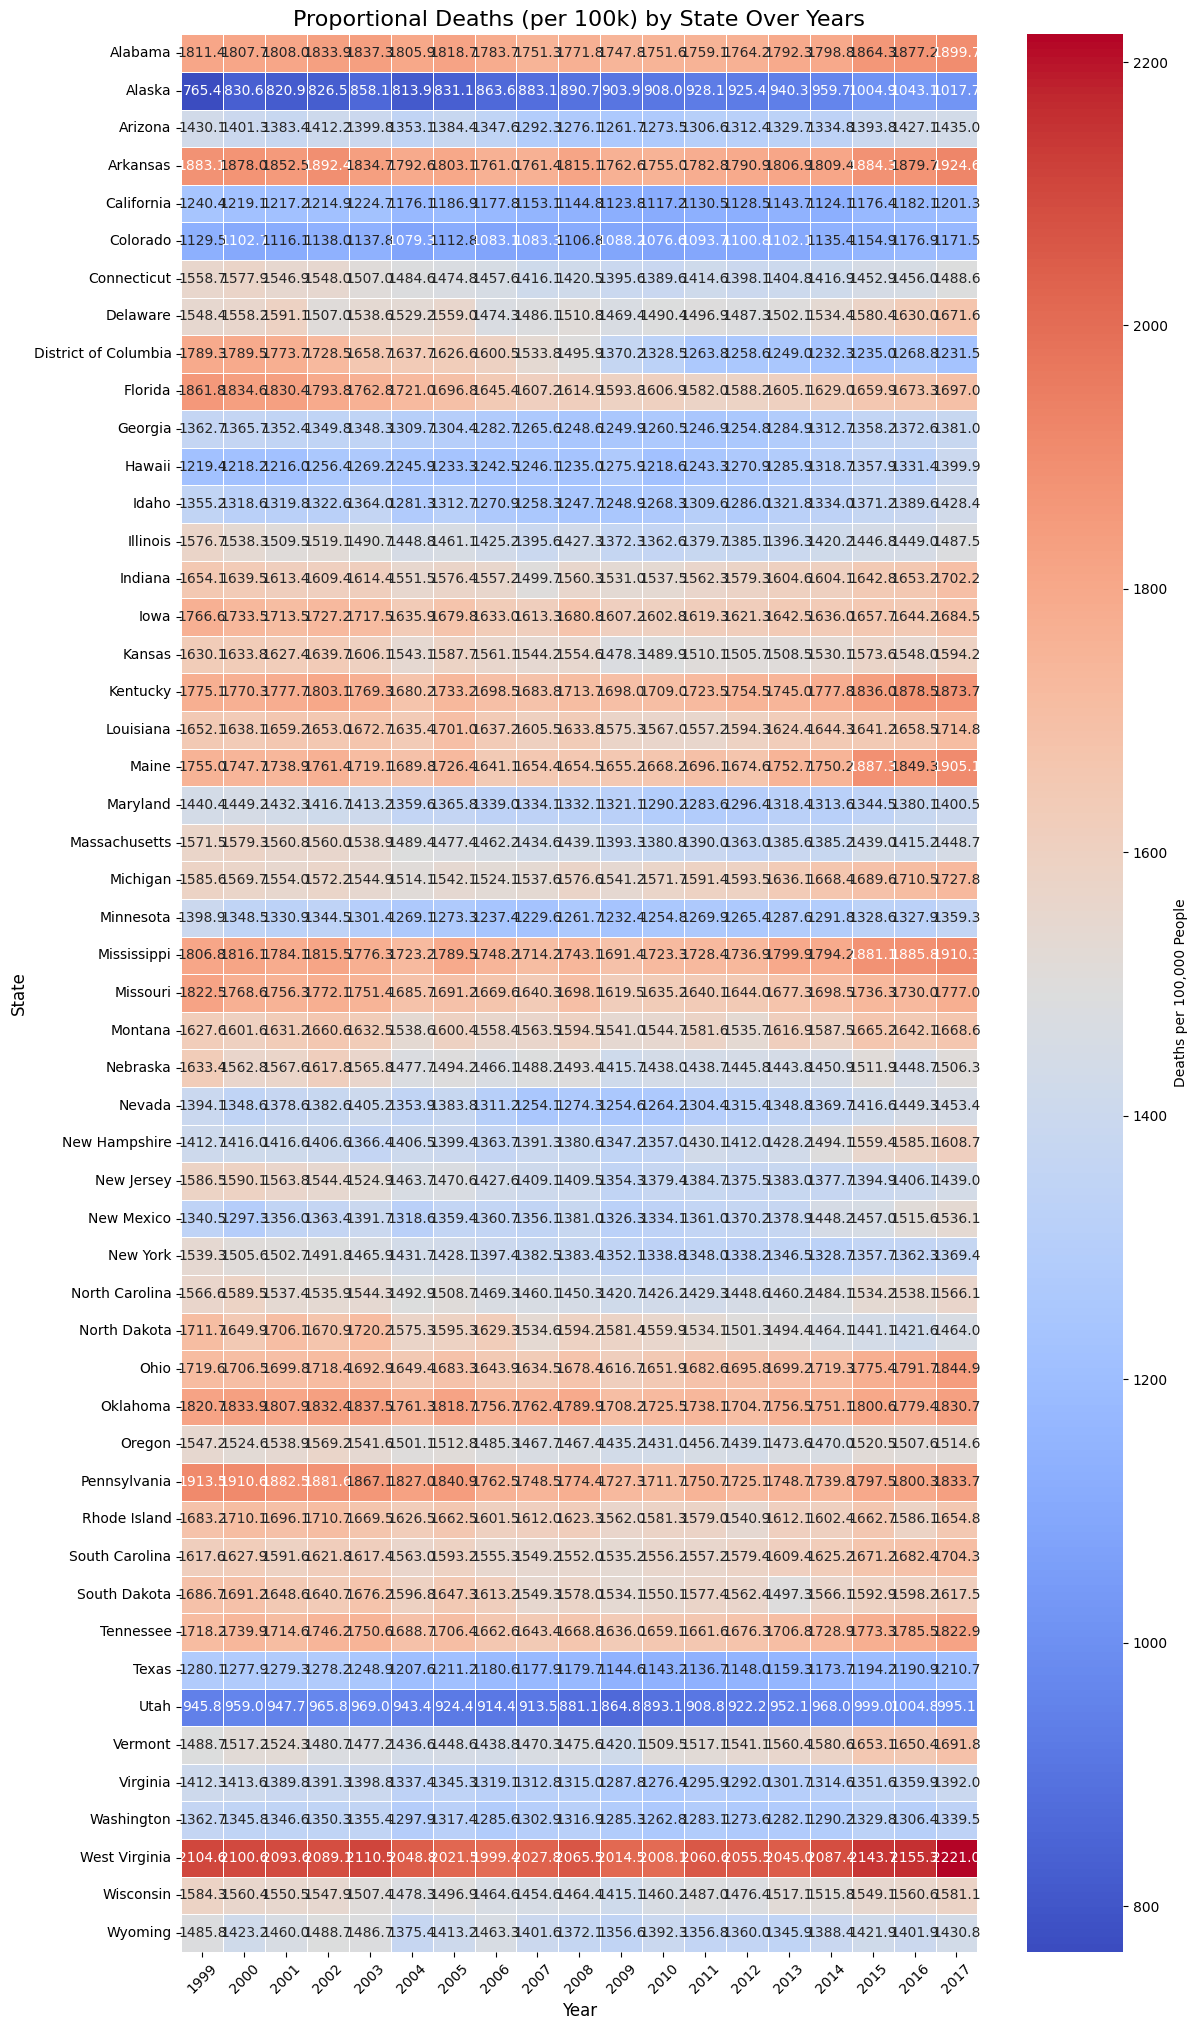

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
# import ace_tools as tools  # For displaying the dataframe

# Load dataset
df = pd.read_csv('../data/processed/US_Deaths_Populations.csv', sep=',')
df_filtered = df[df["State"] != "United States"]


# Aggregate deaths by State and Year
state_year_deaths = df_filtered.groupby(["State", "Year"])["Deaths"].sum().unstack()

# Add population data for each state and year
population_data = df_filtered.groupby(["State", "Year"])["Population"].mean().unstack()

# Calculate proportional deaths per 100k people
proportional_data = (state_year_deaths / population_data) * 100000

# Visualize the proportional deaths
plt.figure(figsize=(12, len(proportional_data) * 0.4))
sns.heatmap(
    proportional_data,
    cmap="coolwarm",
    linewidths=0.5,
    annot=True,
    fmt=".1f",  # Display values as one decimal point
    cbar_kws={"label": "Deaths per 100,000 People"},
)

plt.title("Proportional Deaths (per 100k) by State Over Years", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("State", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


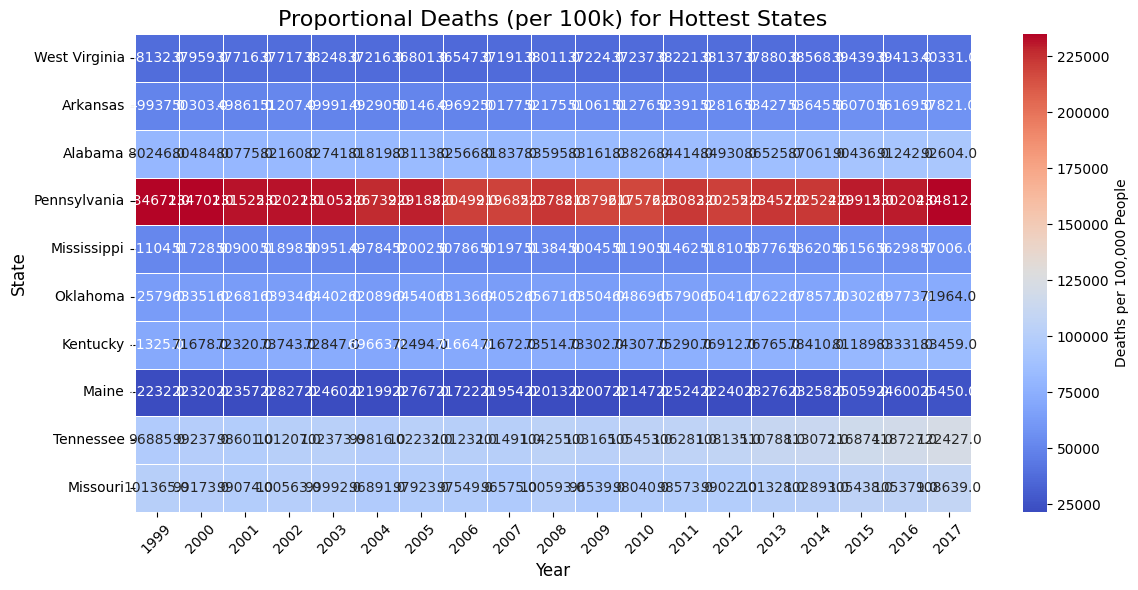

In [57]:
# Identify hottest states (top 10 by proportional deaths)
state_proportional_deaths = state_year_deaths.sum(axis=1) / population_data.sum(axis=1)

# Identify the hottest states (top 10 by proportional deaths)
hottest_states = state_proportional_deaths.nlargest(10).index

# Filter proportional data for hottest states
proportional_data_hottest = state_year_deaths.loc[hottest_states]


# Visualize the heatmap for hottest states
plt.figure(figsize=(12, len(proportional_data_hottest) * 0.6))
sns.heatmap(
    proportional_data_hottest,
    cmap="coolwarm",
    linewidths=0.5,
    annot=True,
    fmt=".1f",
    cbar_kws={"label": "Deaths per 100,000 People"},
)

plt.title("Proportional Deaths (per 100k) for Hottest States", fontsize=16)
plt.xlabel("Year", fontsize=12)
plt.ylabel("State", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


Correlation between total deaths and proportional deaths: -0.04941149891334746


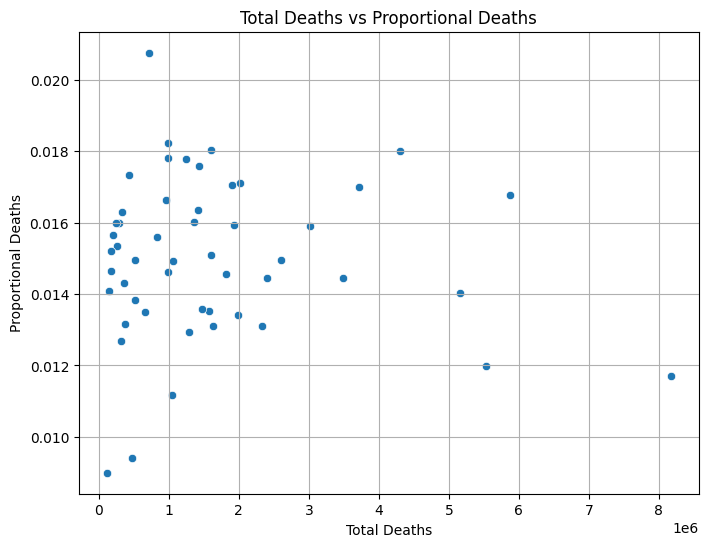

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate total deaths and proportional deaths
total_deaths = state_year_deaths.sum(axis=1)
proportional_deaths = total_deaths / population_data.sum(axis=1)

# Correlation coefficient
correlation = total_deaths.corr(proportional_deaths)
print(f"Correlation between total deaths and proportional deaths: {correlation}")

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=total_deaths, y=proportional_deaths)
plt.title("Total Deaths vs Proportional Deaths")
plt.xlabel("Total Deaths")
plt.ylabel("Proportional Deaths")
plt.grid(True)
plt.show()

# A correlation of -0.049 between total deaths and proportional deaths indicates a very weak (almost negligible) negative relationship. 
# This finding is significant because it shows that states with high total deaths are not necessarily the ones with high proportional deaths.
# A slight negative value might mean that states with higher populations tend to have lower proportional deaths due to population size "diluting" the ratio.

# Possible Causes of Discrepancy:

# 1. Population Size Effect: Large states (e.g., California) dominate total deaths but may have low proportional deaths because their large populations reduce the proportional impact.
# 2. Health Disparities: Small states (e.g., Wyoming) may have lower total deaths but higher proportional deaths due to higher risk factors or poorer access to healthcare.

# Are high proportional deaths driven by low population or high risk factors?
# Are certain regions or states consistently high in proportional deaths?
# How do socioeconomic or health-related factors correlate with proportional deaths?


In [59]:
# Investigate Outliers

# Combine total and proportional deaths into one DataFrame
analysis_df = pd.DataFrame({
    "Total Deaths": total_deaths,
    "Proportional Deaths": proportional_deaths
})

# Calculate IQR for proportional deaths
Q1 = proportional_deaths.quantile(0.25)  # 25th percentile
Q3 = proportional_deaths.quantile(0.75)  # 75th percentile
IQR = Q3 - Q1  # Interquartile Range

# Define outlier thresholds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = proportional_deaths[(proportional_deaths < lower_bound) | (proportional_deaths > upper_bound)]
print(f"Number of Outliers: {len(outliers)}")
print(outliers)

Number of Outliers: 1
State
Alaska    0.008996
dtype: float64


In [60]:
# Investigate the only outlier as "Alaska"
# Filter Alaska's data
alaska_data = df_filtered[df_filtered["State"] == "Alaska"]

# Analyze cause-wise deaths for Alaska
cause_analysis_alaska = alaska_data.groupby("Cause Name")["Deaths"].sum().sort_values(ascending=False)
print("Top Causes of Death in Alaska:")
print(cause_analysis_alaska)

# Compare Alaska to the national average
national_average = df_filtered.groupby("Cause Name")["Deaths"].sum() / df_filtered.groupby("Cause Name")["Population"].sum()
proportional_alaska = cause_analysis_alaska / alaska_data["Population"].sum()
comparison = proportional_alaska - national_average
print("Difference from National Average:")
print(comparison.sort_values(ascending=False))

Top Causes of Death in Alaska:
Cause Name
All causes                 67789
Cancer                     15958
Heart disease              12921
Unintentional injuries      6744
CLRD                        3297
Stroke                      3297
Suicide                     2880
Diabetes                    1920
Alzheimer's disease         1302
Influenza and pneumonia      999
Kidney disease               783
Name: Deaths, dtype: int64
Difference from National Average:
Cause Name
Suicide                   -0.000101
Kidney disease            -0.000144
Influenza and pneumonia   -0.000183
Diabetes                  -0.000230
Alzheimer's disease       -0.000250
Unintentional injuries    -0.000361
CLRD                      -0.000427
Stroke                    -0.000450
Cancer                    -0.001771
Heart disease             -0.002031
All causes                -0.007812
dtype: float64


# Cancer (15,958 deaths) and Heart Disease (12,921 deaths) dominate.
# Unintentional Injuries (6,744 deaths) also stand out, which might reflect unique challenges like accidents or occupational hazards in Alaska.

# Unintentional Injuries?
# Likely driven by harsh climates, remote living conditions, or occupational hazards (e.g., fishing, forestry).

# Suicide Rates:
# Higher-than-average suicide rates might be linked to geographic isolation, mental health challenges, or lack of healthcare access.

# Lower Proportional Death Rates for Heart Disease & Cancer:
# This might reflect Alaska's younger population (compared to states like Florida, with an older population more prone to these diseases).

# Future Analysis
# Investigate Non-Population Drivers

In [61]:
# Aggregate age-adjusted death rates for Alaska
alaska_age_adjusted = df[df["State"] == "Alaska"].groupby("Year")["Age-adjusted Death Rate"].mean()
print(alaska_age_adjusted)

# Compare Alaska's age-adjusted rates to the national average
national_age_adjusted = df[df["State"] == "United States"].groupby("Year")["Age-adjusted Death Rate"].mean()
comparison = alaska_age_adjusted - national_age_adjusted
print("Difference in Age-Adjusted Rates:")
print(comparison)


Year
1999    136.036364
2000    142.281818
2001    132.754545
2002    129.009091
2003    134.772727
2004    121.372727
2005    121.409091
2006    124.809091
2007    123.654545
2008    121.463636
2009    121.390909
2010    121.690909
2011    117.963636
2012    114.581818
2013    113.536364
2014    114.236364
2015    116.336364
2016    116.572727
2017    109.790909
Name: Age-adjusted Death Rate, dtype: float64
Difference in Age-Adjusted Rates:
Year
1999    -7.027273
2000     0.736364
2001    -6.745455
2002    -9.900000
2003    -1.800000
2004   -10.109091
2005    -9.845455
2006    -2.154545
2007    -0.490909
2008    -2.318182
2009     1.900000
2010     2.909091
2011     0.572727
2012    -1.100000
2013    -1.827273
2014    -0.118182
2015     0.418182
2016     1.409091
2017    -5.763636
Name: Age-adjusted Death Rate, dtype: float64


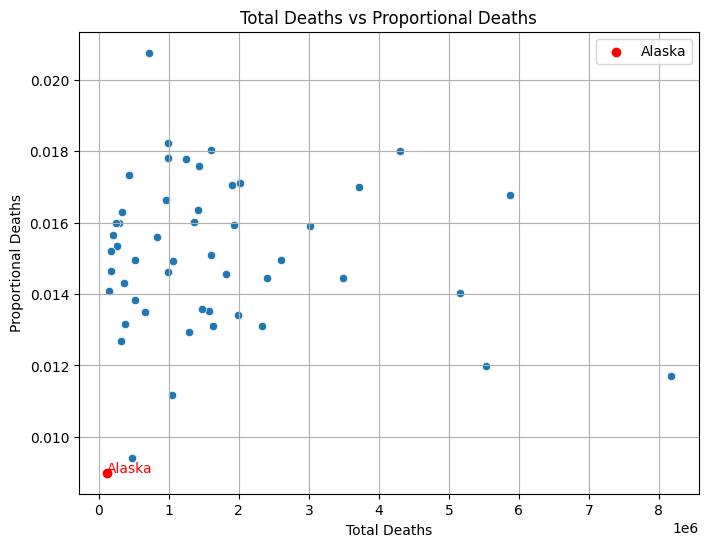

In [62]:
# Scatter plot with Alaska highlighted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=total_deaths, y=proportional_deaths)
plt.title("Total Deaths vs Proportional Deaths")
plt.xlabel("Total Deaths")
plt.ylabel("Proportional Deaths")

# Highlight Alaska in red
alaska_total = total_deaths["Alaska"]
alaska_proportional = proportional_deaths["Alaska"]
plt.scatter(alaska_total, alaska_proportional, color="red", label="Alaska")
plt.text(alaska_total, alaska_proportional, "Alaska", fontsize=10, color="red")

plt.legend()
plt.grid(True)
plt.show()


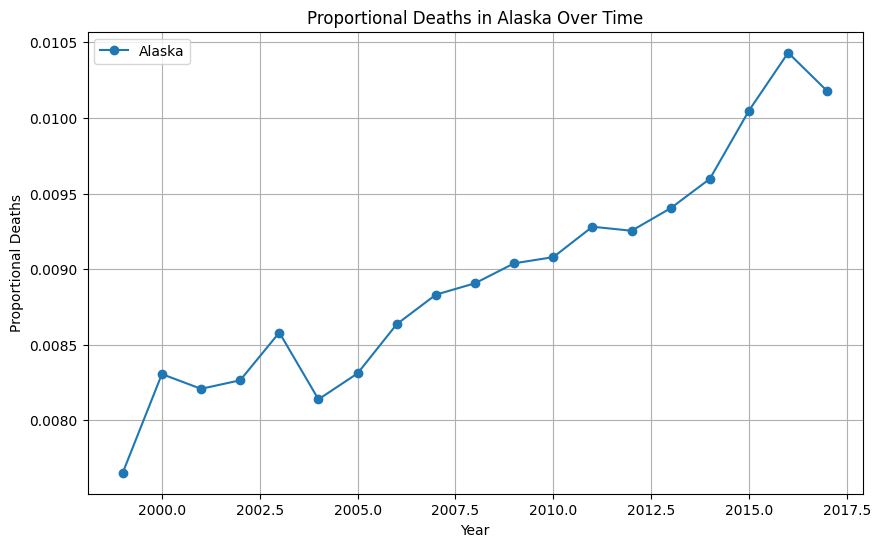

In [63]:
# Proportional deaths for Alaska over time
alaska_proportional_time = (
    state_year_deaths.loc["Alaska"] / population_data.loc["Alaska"]
)
alaska_proportional_time.plot(figsize=(10, 6), marker="o", label="Alaska")

plt.title("Proportional Deaths in Alaska Over Time")
plt.xlabel("Year")
plt.ylabel("Proportional Deaths")
plt.legend()
plt.grid(True)
plt.show()


In [64]:
# National average with Alaska
with_alaska = proportional_deaths.mean()

# National average without Alaska
without_alaska = proportional_deaths[proportional_deaths.index != "Alaska"].mean()

print(f"With Alaska: {with_alaska}")
print(f"Without Alaska: {without_alaska}")


With Alaska: 0.015016774485410962
Without Alaska: 0.015137198099737417


Correlation between Population and Proportional Deaths: -0.17624854882685695


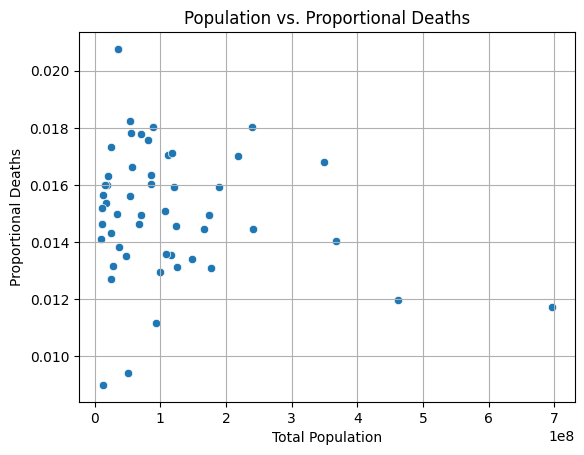

In [65]:
# Population Size Effect
# Add population data
analysis_df["Total Population"] = population_data.sum(axis=1)

# Correlation between population and proportional deaths
population_correlation = analysis_df["Total Population"].corr(analysis_df["Proportional Deaths"])
print(f"Correlation between Population and Proportional Deaths: {population_correlation}")

# Scatter plot
sns.scatterplot(x="Total Population", y="Proportional Deaths", data=analysis_df)
plt.title("Population vs. Proportional Deaths")
plt.xlabel("Total Population")
plt.ylabel("Proportional Deaths")
plt.grid(True)
plt.show()